In [2]:
!python -m pip install pyradiomics

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 734.1/734.1 kB 19.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 86.8 MB/s  0:00:00
  DEPRECATION: Building 'docopt' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'docopt'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13783 sha256=a1b4e0b16762cc4814da1d5d4ae45049a51231e9e7a776be8c9a198b90c3e205
  Stored in directory: /home/pansurya/.cache/pip/wheels/70/4a/46/1309fc853b8d395e60bafaf1b6df7845bdd82c95fd59dd8d2b
Successfully built docopt
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [pyradi

In [ ]:
#this code for binary mask
import os, csv, logging, shutil, threading
from collections import OrderedDict
from datetime import datetime
from multiprocessing import Pool, cpu_count

import SimpleITK as sitk
import radiomics
from radiomics.featureextractor import RadiomicsFeatureExtractor

threading.current_thread().name = "Main"

# File variables
ROOT = f"/home/pansurya/OSIC_thesis"

# Define your results directory
RESULTS_DIR = os.path.join(os.getcwd(), "radiomics_files")

# Create it if it doesn't exist
os.makedirs(RESULTS_DIR, exist_ok=True)

print(f"Radiomic files will be stored in: {RESULTS_DIR}")
PARAMS = os.path.join(ROOT, RESULTS_DIR, "Pyradiomics_Params.yaml")  # your YAML settings
LOG = os.path.join(ROOT, RESULTS_DIR, "Radiomicslog.txt")
OUTPUTCSV = os.path.join(ROOT, RESULTS_DIR, "RadiomicsFeaturesresults.csv")

TEMP_DIR = "_TEMP"
REMOVE_TEMP_DIR = True
NUM_OF_WORKERS = max(cpu_count() - 1, 1)

# Logging
rLogger = radiomics.logger
logHandler = logging.FileHandler(filename=LOG, mode="a")
logHandler.setLevel(logging.INFO)
logHandler.setFormatter(logging.Formatter("%(levelname)-.1s: (%(threadName)s) %(name)s: %(message)s"))
rLogger.addHandler(logHandler)

# ---------------------------
# Build list of cases from folder structure
# ---------------------------
def collect_cases(patients_root):
    cases = []
    
    for patient in os.listdir(patients_root):
        pdir = os.path.join(patients_root, patient)
        if not os.path.isdir(pdir):
            continue

        # find baseline folder
        for baseline in os.listdir(pdir):
            if baseline.startswith("baseline_"):
                baseline_dir = os.path.join(pdir, baseline)
                if not os.path.isdir(baseline_dir):
                    continue

                # parse date from folder name
                baseline_date = baseline.replace("baseline_", "")

                # find series UID folder
                series_folders = [f for f in os.listdir(baseline_dir) if f.startswith("1.")]
                if not series_folders:
                    continue
                series_uid = series_folders[0]
                
                # find CT NIfTI and mask
                nifty_dir = [d for d in os.listdir(baseline_dir) if d.endswith("_NIfTY")]
                mask_dir = [d for d in os.listdir(baseline_dir) if d.endswith("_Mask")]
                if not nifty_dir or not mask_dir:
                    continue
               
                ct_path = os.path.join(baseline_dir, nifty_dir[0], os.listdir(os.path.join(baseline_dir, nifty_dir[0]))[0])
                mask_path = os.path.join(baseline_dir, mask_dir[0], os.listdir(os.path.join(baseline_dir, mask_dir[0]))[0])

                # parse patient ID from mask filename (e.g. 865785_baseline_1969-10-06_mask.nii.gz)
                fname = os.path.basename(mask_path)
                patient_id = fname.split("_")[0]
                

                cases.append({
                    "PatientID": patient_id,
                    "BaselineDate": baseline_date,
                    "SeriesUID": series_uid,
                    "Image": ct_path,
                    "Mask": mask_path
                })
    return cases

# ---------------------------
# Run extraction for one case
# ---------------------------
def run(case):
    ptLogger = logging.getLogger("radiomics.batch")
    feature_vector = OrderedDict(case)

    try:
        threading.current_thread().name = case["PatientID"]
        extractor = RadiomicsFeatureExtractor(PARAMS)

        # Extract features
        feats = extractor.execute(case["Image"], case["Mask"])
        # Keep only features (drop diagnostics)
        for k, v in feats.items():
            if k.startswith(("original", "log", "wavelet")):
                feature_vector[k] = v

        # Save temporary file
        os.makedirs(TEMP_DIR, exist_ok=True)
        out_file = os.path.join(TEMP_DIR, f"features_{case['PatientID']}.csv")
        with open(out_file, "w") as f:
            writer = csv.DictWriter(f, fieldnames=list(feature_vector.keys()))
            writer.writeheader()
            writer.writerow(feature_vector)

        ptLogger.info("Processed patient %s", case["PatientID"])

    except Exception:
        ptLogger.error("Feature extraction failed for %s", case["PatientID"], exc_info=True)

    return feature_vector

# ---------------------------
# Main
# ---------------------------
if __name__ == "__main__":
    logger = logging.getLogger("radiomics.batch")
    sitk.ProcessObject_SetGlobalDefaultNumberOfThreads(1)

    patients_root = os.path.join(ROOT, "PATIENTS_DICOM_STRUCTURE_MAIN")  # adjust path
    cases = collect_cases(patients_root)
    logger.info("Found %d cases", len(cases))

    pool = Pool(NUM_OF_WORKERS)
    results = pool.map(run, cases)

    # Write combined CSV
    if results:
        with open(OUTPUTCSV, "w") as out:
            writer = csv.DictWriter(out, fieldnames=list(results[0].keys()))
            writer.writeheader()
            writer.writerows(results)
        logger.info("Saved results to %s", OUTPUTCSV)

        if REMOVE_TEMP_DIR:
            shutil.rmtree(TEMP_DIR, ignore_errors=True)


Radiomic files will be stored in: /home/pansurya/OSIC_thesis/radiomics_files


validation.invalid
 --- All found errors ---
validation.invalid
validation.invalid
["Key 'label_interpolator' was not defined. Path: '/setting'"]
validation.invalid
 --- All found errors ---
Feature extraction failed for 1006781
Traceback (most recent call last):
  File "/tmp/ipykernel_951388/3363370425.py", line 97, in run
    extractor = RadiomicsFeatureExtractor(PARAMS)
  File "/home/pansurya/.local/lib/python3.9/site-packages/radiomics/featureextractor.py", line 63, in __init__
    self._applyParams(paramsFile=args[0])
  File "/home/pansurya/.local/lib/python3.9/site-packages/radiomics/featureextractor.py", line 170, in _applyParams
    params = c.validate()
  File "/home/pansurya/.local/lib/python3.9/site-packages/pykwalify/core.py", line 194, in validate
    raise SchemaError(u"Schema validation failed:\n - {error_msg}.".format(
pykwalify.errors.SchemaError: <SchemaError: error code 2: Schema validation failed:
 - Key 'label_interpolator' was not defined. Path: '/setting'.: Path:

In [ ]:
import os, csv, logging, shutil, threading
from collections import OrderedDict
from datetime import datetime
from multiprocessing import Pool, cpu_count

import SimpleITK as sitk
import radiomics
from radiomics.featureextractor import RadiomicsFeatureExtractor

threading.current_thread().name = "Main"

# File variables
ROOT = f"/home/pansurya/OSIC_thesis"

# Define your results directory
RESULTS_DIR = os.path.join(os.getcwd(), "radiomics_files")

# Create it if it doesn't exist
os.makedirs(RESULTS_DIR, exist_ok=True)

print(f"Radiomic files will be stored in: {RESULTS_DIR}")
PARAMS = os.path.join(ROOT, RESULTS_DIR, "Pyradiomics_Params.yaml")  # your YAML settings
LOG = os.path.join(ROOT, RESULTS_DIR, "Radiomicslog.txt")
OUTPUTCSV = os.path.join(ROOT, RESULTS_DIR, "RadiomicsFeaturesresults_main.csv")

TEMP_DIR = "_TEMP"
REMOVE_TEMP_DIR = True
NUM_OF_WORKERS = max(cpu_count() - 1, 1)

# Logging
rLogger = radiomics.logger
logHandler = logging.FileHandler(filename=LOG, mode="a")
logHandler.setLevel(logging.INFO)
logHandler.setFormatter(logging.Formatter("%(levelname)-.1s: (%(threadName)s) %(name)s: %(message)s"))
rLogger.addHandler(logHandler)

# ---------------------------
# Build list of cases from folder structure
# ---------------------------
def collect_cases(patients_root):
    cases = []
    
    for patient in os.listdir(patients_root):
        pdir = os.path.join(patients_root, patient)
        if not os.path.isdir(pdir):
            continue

        # find baseline folder
        for baseline in os.listdir(pdir):
            if baseline.startswith("baseline_"):
                baseline_dir = os.path.join(pdir, baseline)
                if not os.path.isdir(baseline_dir):
                    continue

                # parse date from folder name
                baseline_date = baseline.replace("baseline_", "")

                # find series UID folder
                series_folders = [f for f in os.listdir(baseline_dir) if f.startswith("1.")]
                if not series_folders:
                    continue
                series_uid = series_folders[0]
                
                # find CT NIfTI and mask
                nifty_dir = [d for d in os.listdir(baseline_dir) if d.endswith("_NIfTY")]
                mask_dir = [d for d in os.listdir(baseline_dir) if d.endswith("_Mask")]
                if not nifty_dir or not mask_dir:
                    continue
               
                ct_path = os.path.join(baseline_dir, nifty_dir[0], os.listdir(os.path.join(baseline_dir, nifty_dir[0]))[0])
                mask_path = os.path.join(baseline_dir, mask_dir[0], os.listdir(os.path.join(baseline_dir, mask_dir[0]))[0])

                # parse patient ID from mask filename (e.g. 865785_baseline_1969-10-06_mask.nii.gz)
                fname = os.path.basename(mask_path)
                patient_id = fname.split("_")[0]
                

                cases.append({
                    "PatientID": patient_id,
                    "BaselineDate": baseline_date,
                    "SeriesUID": series_uid,
                    "Image": ct_path,
                    "Mask": mask_path
                })
    return cases

# ---------------------------
# Run extraction for one case
# ---------------------------
def run(case):
    ptLogger = logging.getLogger("radiomics.batch")
    feature_vector = OrderedDict(case)

    try:
        threading.current_thread().name = case["PatientID"]
        extractor = RadiomicsFeatureExtractor(PARAMS)

        mask_labels = {'right_lung':1, 'left_lung':2}
        for k_lbl, v_lbl in mask_labels.items():
            feats = extractor.execute(case["Image"], case["Mask"], label=v_lbl)
            for k, v in feats.items():
                if k.startswith(("original", "log", "wavelet")):
                    feature_vector[f"{k}_{k_lbl}"] = v


        # Save temporary file
        os.makedirs(TEMP_DIR, exist_ok=True)
        out_file = os.path.join(TEMP_DIR, f"features_{case['PatientID']}.csv")
        with open(out_file, "w") as f:
            writer = csv.DictWriter(f, fieldnames=list(feature_vector.keys()))
            writer.writeheader()
            writer.writerow(feature_vector)

        ptLogger.info("Processed patient %s", case["PatientID"])

    except Exception:
        ptLogger.error("Feature extraction failed for %s", case["PatientID"], exc_info=True)

    return feature_vector

# ---------------------------
# Main
# ---------------------------
if __name__ == "__main__":
    logger = logging.getLogger("radiomics.batch")
    sitk.ProcessObject_SetGlobalDefaultNumberOfThreads(1)

    patients_root = os.path.join(ROOT, "PATIENTS_DICOM_STRUCTURE")  # adjust path
    cases = collect_cases(patients_root)
    logger.info("Found %d cases", len(cases))

    pool = Pool(NUM_OF_WORKERS)
    results = pool.map(run, cases)

    # Write combined CSV
    if results:
        with open(OUTPUTCSV, "w") as out:
            writer = csv.DictWriter(out, fieldnames=list(results[0].keys()))
            writer.writeheader()
            writer.writerows(results)
        logger.info("Saved results to %s", OUTPUTCSV)

        if REMOVE_TEMP_DIR:
            shutil.rmtree(TEMP_DIR, ignore_errors=True)


Radiomic files will be stored in: /home/pansurya/OSIC_thesis/radiomics_files


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Avera

In [ ]:

import os
import numpy as np
import pandas as pd
import SimpleITK as sitk
from radiomics import featureextractor

# ---------------------------
# Load your Params.yaml
# ---------------------------
PARAMS = "/home/pansurya/OSIC_thesis/radiomics_files/Pyradiomics_Params.yaml"   # path to your validated YAML file

extractor = featureextractor.RadiomicsFeatureExtractor(PARAMS)

# ---------------------------
# 1. Reproducibility check
# ---------------------------
def reproducibility_check(ct_path, mask_path):
    """Run extraction twice and compare results."""
    f1 = extractor.execute(ct_path, mask_path)
    f2 = extractor.execute(ct_path, mask_path)

    # Keep only feature values (drop diagnostics)
    f1 = {k: v for k, v in f1.items() if k.startswith(("original", "log", "wavelet"))}
    f2 = {k: v for k, v in f2.items() if k.startswith(("original", "log", "wavelet"))}
    print(f1)
    print(f2)

    diffs = {k: abs(f1[k] - f2[k]) for k in f1.keys()}
    print(diffs)
    max_diff = max(diffs.values())
    print(f"[Reproducibility] Max absolute difference: {max_diff:.6f}")
    return max_diff

# ---------------------------
# 2. Plausibility check
# ---------------------------
def plausibility_check(features):
    """Check if key features fall in expected ranges for lung CT."""
    mean_hu = features.get("original_firstorder_Mean", None)
    if mean_hu is not None:
        if -1000 <= mean_hu <= 200:
            print(f"[Plausibility] Mean HU = {mean_hu:.2f} ✅ plausible")
        else:
            print(f"[Plausibility] Mean HU = {mean_hu:.2f} ⚠️ out of expected range")

    energy = features.get("original_firstorder_Energy", None)
    if energy is not None and energy < 0:
        print(f"[Plausibility] Energy negative ⚠️ check preprocessing")

# ---------------------------
# 3. Robustness check
# ---------------------------
def robustness_check(ct_path, mask_path):
    """Apply small perturbation (mask erosion) and compare features."""
    img = sitk.ReadImage(ct_path)
    mask = sitk.ReadImage(mask_path)

    # Original features
    f_orig = extractor.execute(img, mask)
    f_orig = {k: v for k, v in f_orig.items() if k.startswith(("original", "log", "wavelet"))}

    # Perturb mask: erode by 1 voxel
    eroder = sitk.BinaryErodeImageFilter()
    eroder.SetKernelRadius(1)
    mask_eroded = eroder.Execute(mask)

    f_eroded = extractor.execute(img, mask_eroded)
    f_eroded = {k: v for k, v in f_eroded.items() if k.startswith(("original", "log", "wavelet"))}

    # Compare
    diffs = {k: abs(f_orig[k] - f_eroded[k]) for k in f_orig.keys()}
    unstable = [k for k, d in diffs.items() if d > 1e-3 * abs(f_orig[k]) + 1e-6]

    print(f"[Robustness] {len(unstable)} features changed >0.1% after mask erosion")
    return unstable

# ---------------------------
# Example usage
# ---------------------------
if __name__ == "__main__":
    ct_path = "/home/pansurya/OSIC_thesis/PATIENTS_DICOM_STRUCTURE_MAIN/1006459/baseline_1966-05-01/1006459_baseline_1966-05-01_NIfTY/1006459_baseline_1966-05-01.nii.gz"
    mask_path = "/home/pansurya/OSIC_thesis/PATIENTS_DICOM_STRUCTURE_MAIN/1006982/followup_1973-07-01/1006982_followup_1973-07-01_Mask/1006982_followup_1973-07-01_mask.nii.gz"

    # 1. Reproducibility
    reproducibility_check(ct_path, mask_path)

    # 2. Plausibility
    feats = extractor.execute(ct_path, mask_path)
    feats = {k: v for k, v in feats.items() if k.startswith(("original", "log", "wavelet"))}
    plausibility_check(feats)

    # 3. Robustness
    robustness_check(ct_path, mask_path)


validation.invalid
 --- All found errors ---
["Key 'label_interpolator' was not defined. Path: '/setting'"]


SchemaError: <SchemaError: error code 2: Schema validation failed:
 - Key 'label_interpolator' was not defined. Path: '/setting'.: Path: '/'>

Resampled CT spacing: (1.0, 1.0, 1.0), Mask spacing: (1.0, 1.0, 1.0)


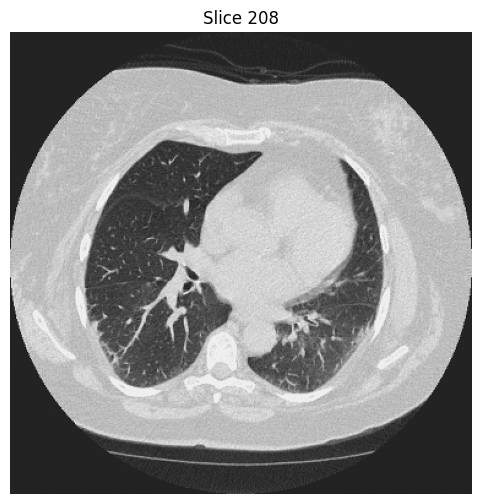

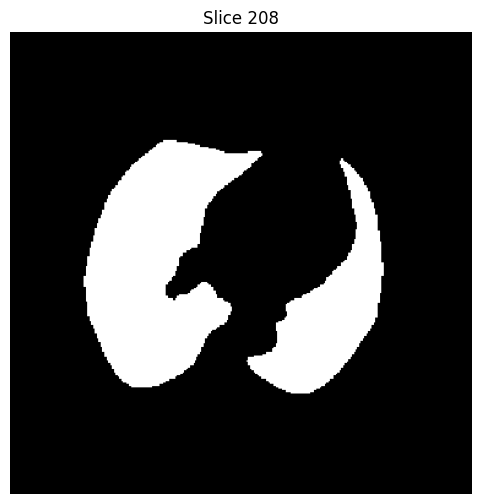


--- PyRadiomics CT metadata ---
Size (X,Y,Z): (377, 377, 416)
Spacing (X,Y,Z): (1.0, 1.0, 1.0)
Origin: (0.0, 0.0, 0.0)
Direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)

--- PyRadiomics MASK metadata ---
Size (X,Y,Z): (377, 377, 416)
Spacing (X,Y,Z): (1.0, 1.0, 1.0)
Origin: (0.0, 0.0, 0.0)
Direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)


Process ForkPoolWorker-74:
Process ForkPoolWorker-75:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib64/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib64/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib64/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib64/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib64/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/usr/lib64/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()


KeyboardInterrupt: 

  File "/usr/lib64/python3.9/multiprocessing/queues.py", line 364, in get
    with self._rlock:


  File "/usr/lib64/python3.9/multiprocessing/queues.py", line 365, in get
    res = self._reader.recv_bytes()
  File "/usr/lib64/python3.9/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib64/python3.9/multiprocessing/connection.py", line 220, in recv_bytes
    buf = self._recv_bytes(maxlength)
KeyboardInterrupt
  File "/usr/lib64/python3.9/multiprocessing/connection.py", line 418, in _recv_bytes
    buf = self._recv(4)
  File "/usr/lib64/python3.9/multiprocessing/connection.py", line 383, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt
Process ForkPoolWorker-73:
Traceback (most recent call last):
  File "/usr/lib64/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib64/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib64/python3.9/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*arg

In [ ]:
import os, csv, logging, shutil, threading
from collections import OrderedDict
from multiprocessing import Pool
import numpy as np
import nibabel as nib
import SimpleITK as sitk
import radiomics
from radiomics.featureextractor import RadiomicsFeatureExtractor
import matplotlib.pyplot as plt

threading.current_thread().name = "Main"

# ============================================================
# Paths
# ============================================================
ROOT = "/home/pansurya/OSIC_thesis"
RESULTS_DIR = os.path.join(os.getcwd(), "radiomics_files")
os.makedirs(RESULTS_DIR, exist_ok=True)

PARAMS = os.path.join(ROOT, RESULTS_DIR, "Pyradiomics_Params.yaml")
LOG = os.path.join(ROOT, RESULTS_DIR, "Radiomicslog111.txt")
OUTPUTCSV = os.path.join(ROOT, RESULTS_DIR, "RadiomicsFeaturesresultscovidResmpling_main.csv")

TEMP_DIR = "_TEMP111"
REMOVE_TEMP_DIR = True
NUM_OF_WORKERS = max(4, 1)

# ============================================================
# Logging
# ============================================================
rLogger = radiomics.logger
logHandler = logging.FileHandler(filename=LOG, mode="a")
logHandler.setLevel(logging.INFO)
logHandler.setFormatter(logging.Formatter("%(levelname)-.1s: (%(threadName)s) %(name)s: %(message)s"))
rLogger.addHandler(logHandler)

# ============================================================
# Patients to exclude
# ============================================================
EXCLUDE_PATIENTS = {
    "1000986","1000641","1000658","1001215","1001138","1002744",
    "1001244","1001117","1001137","1000985",
    "1001198","1002407","1000635","1001029","1001115"
}

# ============================================================
# Helper: Get spacing in (Z,Y,X)
# ============================================================
def get_spacing_from_nifti(nii):
    zooms = nii.header.get_zooms()[:3]  # (x, y, z)
    return (zooms[2], zooms[1], zooms[0])

# ============================================================
# Helper: Resample volume (your function)
# ============================================================
def resample_volume(ct_array, original_spacing, new_spacing=(1, 1, 1), interpolator=None):

    if interpolator is None:
        interpolator = sitk.sitkBSpline

    image_itk = sitk.GetImageFromArray(ct_array)

    # SimpleITK expects spacing in (x, y, z)
    image_itk.SetSpacing(tuple(float(s) for s in original_spacing[::-1]))

    original_size = np.array(image_itk.GetSize(), dtype=np.int32)
    original_spacing_np = np.array(original_spacing, dtype=np.float64)
    new_spacing_np = np.array(new_spacing, dtype=np.float64)

    new_size = np.round(original_size * (original_spacing_np[::-1] / new_spacing_np[::-1])).astype(int)

    resampler = sitk.ResampleImageFilter()
    resampler.SetOutputSpacing(tuple(float(s) for s in new_spacing_np[::-1]))
    resampler.SetSize([int(s) for s in new_size])
    resampler.SetOutputDirection(image_itk.GetDirection())
    resampler.SetOutputOrigin(image_itk.GetOrigin())
    resampler.SetInterpolator(interpolator)

    resampled_itk = resampler.Execute(image_itk)
    resampled_array = sitk.GetArrayFromImage(resampled_itk)

    actual_spacing = resampled_itk.GetSpacing()[::-1]

    return resampled_array, actual_spacing


# ============================================================
# Build list of cases
# ============================================================
def collect_cases(patients_root):
    cases = []
    p = ['1001305']
    for patient in p:
        pdir = os.path.join(patients_root, patient)
        if not os.path.isdir(pdir):
            continue

        for baseline in os.listdir(pdir):
            if baseline.startswith("baseline_"):
                baseline_dir = os.path.join(pdir, baseline)
                if not os.path.isdir(baseline_dir):
                    continue

                baseline_date = baseline.replace("baseline_", "")
                series_folders = [f for f in os.listdir(baseline_dir) if f.startswith("1.")]
                if not series_folders:
                    continue

                nifty_dir = [d for d in os.listdir(baseline_dir) if d.endswith("_NIfTY")]
                mask_dir = [d for d in os.listdir(baseline_dir) if d.endswith("_R231CovidWeb")]
                if not nifty_dir or not mask_dir:
                    continue

                ct_path = os.path.join(baseline_dir, nifty_dir[0], os.listdir(os.path.join(baseline_dir, nifty_dir[0]))[0])
                mask_path = os.path.join(baseline_dir, mask_dir[0], os.listdir(os.path.join(baseline_dir, mask_dir[0]))[0])

                patient_id = os.path.basename(mask_path).split("_")[0]

                if patient_id in EXCLUDE_PATIENTS:
                    continue

                existing_csv = os.path.join(TEMP_DIR, f"features_{patient_id}.csv")
                if os.path.exists(existing_csv):
                    logging.getLogger("radiomics.batch").info(
                        f"Skipping patient {patient_id} (already processed)"
                    )
                    continue

                cases.append({
                    "PatientID": patient_id,
                    "BaselineDate": baseline_date,
                    "Image": ct_path,
                    "Mask": mask_path
                })

    return cases

# ============================================================
# Run extraction for one case
# ============================================================
def run(case):
    ptLogger = logging.getLogger("radiomics.batch")
    feature_vector = OrderedDict(case)

    try:
        threading.current_thread().name = case["PatientID"]
        extractor = RadiomicsFeatureExtractor(PARAMS)

        # # Disable PyRadiomics resampling
        # extractor.settings["resampledPixelSpacing"] = None
        # extractor.settings["interpolator"] = None

        # Load CT + mask
        nii_ct = nib.load(case["Image"])
        nii_mask = nib.load(case["Mask"])

        ct_array = nii_ct.get_fdata().astype(np.int16)
        mask_array = nii_mask.get_fdata().astype(np.int16)

        ct_spacing = get_spacing_from_nifti(nii_ct)
        mask_spacing = get_spacing_from_nifti(nii_mask)

        # Resample both to 1mm
        new_spacing = (1,1,1)
        resampled_ct, ct_new_spacing = resample_volume(ct_array, ct_spacing)
        resampled_mask, mask_new_spacing = resample_volume(
        mask_array,
        mask_spacing,
        new_spacing=new_spacing,
        interpolator=sitk.sitkNearestNeighbor
    )
        print(f"Resampled CT spacing: {ct_new_spacing}, Mask spacing: {mask_new_spacing}")
        # Convert back to SimpleITK
        ct_itk = sitk.GetImageFromArray(resampled_ct)
        ct_itk.SetSpacing(ct_new_spacing[::-1])

        mask_itk = sitk.GetImageFromArray(resampled_mask)
        mask_itk.SetSpacing(mask_new_spacing[::-1])


        print("\n--- PyRadiomics CT metadata ---")
        print("Size (X,Y,Z):", ct_itk.GetSize())
        print("Spacing (X,Y,Z):", ct_itk.GetSpacing())
        print("Origin:", ct_itk.GetOrigin())
        print("Direction:", ct_itk.GetDirection())

        print("\n--- PyRadiomics MASK metadata ---")
        print("Size (X,Y,Z):", mask_itk.GetSize())
        print("Spacing (X,Y,Z):", mask_itk.GetSpacing())
        print("Origin:", mask_itk.GetOrigin())
        print("Direction:", mask_itk.GetDirection())


        # # Extract features
        # feats = extractor.execute(ct_itk, mask_itk, label=1)

        # for k, v in feats.items():
        #     if k.startswith(("original", "log", "wavelet")):
        #         feature_vector[k] = v


        mask_labels = {'right_lung':1, 'left_lung':2}
        for k_lbl, v_lbl in mask_labels.items():
            feats = extractor.execute(case["Image"], case["Mask"], label=v_lbl)
            for k, v in feats.items():
                if k.startswith(("original", "log", "wavelet")):
                    feature_vector[f"{k}_{k_lbl}"] = v

        os.makedirs(TEMP_DIR, exist_ok=True)
        out_file = os.path.join(TEMP_DIR, f"features_{case['PatientID']}.csv")
        with open(out_file, "w") as f:
            writer = csv.DictWriter(f, fieldnames=list(feature_vector.keys()))
            writer.writeheader()
            writer.writerow(feature_vector)

        ptLogger.info("Processed patient %s", case["PatientID"])

    except Exception:
        ptLogger.error("Feature extraction failed for %s", case["PatientID"], exc_info=True)

    return feature_vector

# ============================================================
# Main
# ============================================================
if __name__ == "__main__":
    logger = logging.getLogger("radiomics.batch")

    patients_root = "/scratch/bds/OSIC/PATIENTS_DICOM_STRUCTURE_MAIN"
    cases = collect_cases(patients_root)
    logger.info("Found %d cases", len(cases))

    pool = Pool(NUM_OF_WORKERS)
    results = pool.map(run, cases)

    if results:
        with open(OUTPUTCSV, "w") as out:
            writer = csv.DictWriter(out, fieldnames=list(results[0].keys()))
            writer.writeheader()
            writer.writerows(results)

        logger.info("Saved results to %s", OUTPUTCSV)

        if REMOVE_TEMP_DIR:
            shutil.rmtree(TEMP_DIR, ignore_errors=True)


In [4]:
import os

folder_path = "/home/pansurya/OSIC_thesis/_TEMP2ROICovid"

csv_count = len([f for f in os.listdir(folder_path) if f.endswith(".csv")])
print("Number of CSV files:", csv_count)


Number of CSV files: 554


In [2]:
import os
import pandas as pd

# --- INPUTS ---
main_csv = "/home/pansurya/OSIC_thesis/radiomics_files/RadiomicsFeaturesresults_main.csv"   # CSV containing PatientID column
csv_folder = "/home/pansurya/OSIC_thesis/_TEMP"                # folder containing features_XXXX.csv files

# --- READ PATIENT IDs FROM MAIN CSV ---
df = pd.read_csv(main_csv)
patient_ids = df["PatientID"].astype(str).str.strip().tolist()

# --- GET PATIENT IDs FROM CSV FILENAMES ---
csv_files = os.listdir(csv_folder)

csv_patient_ids = []
for fname in csv_files:
    if fname.startswith("features_") and fname.endswith(".csv"):
        pid = fname.replace("features_", "").replace(".csv", "")
        csv_patient_ids.append(pid)

# --- FIND MISSING PATIENTS ---
missing = sorted(set(patient_ids) - set(csv_patient_ids))

print("Patients missing CSV files:")
for pid in missing:
    print(pid)

print(f"\nTotal missing: {len(missing)}")


Patients missing CSV files:

Total missing: 0


In [5]:
import os
import pandas as pd

# --- INPUTS ---
csv_folder = "/home/pansurya/OSIC_thesis/_TEMP2ROICovid"   # folder containing features_XXXX.csv files
main_csv = "/home/pansurya/OSIC_thesis/radiomics_files/RadiomicsFeaturesresults2ROICovid_main.csv"

# --- READ EXISTING MAIN CSV (if it exists) ---
if os.path.exists(main_csv):
    main_df = pd.read_csv(main_csv)
else:
    main_df = pd.DataFrame()

# --- READ ALL NEW CSV FILES FROM FOLDER ---
new_dfs = []
for fname in os.listdir(csv_folder):
    if fname.endswith(".csv"):
        fpath = os.path.join(csv_folder, fname)
        df = pd.read_csv(fpath)
        new_dfs.append(df)

# Combine all new CSVs
if new_dfs:
    new_df = pd.concat(new_dfs, ignore_index=True, sort=False)
else:
    new_df = pd.DataFrame()

# --- CONCATENATE MAIN + NEW DATA ---
combined_df = pd.concat([main_df, new_df], ignore_index=True, sort=False)

# --- REMOVE DUPLICATE PATIENTS ---
combined_df = combined_df.drop_duplicates(subset=["PatientID"], keep="first")

# --- SAVE BACK TO MAIN CSV ---
combined_df.to_csv(main_csv, index=False)

print("Merged data saved to:", main_csv)
print("Total unique patients:", combined_df['PatientID'].nunique())


Merged data saved to: /home/pansurya/OSIC_thesis/radiomics_files/RadiomicsFeaturesresults2ROICovid_main.csv
Total unique patients: 554


In [11]:
import pandas as pd
import numpy as np

# Load your full metadata CSV
df = pd.read_csv("/home/pansurya/OSIC_thesis/radiomics_files/testing.csv")

# --- Clean and prepare ---
df["Baseline FVC Volume L"] = pd.to_numeric(df["Baseline FVC Volume L"], errors="coerce")
df["Age"] = pd.to_numeric(df["Age"], errors="coerce")
df["Thickness (mm)"] = pd.to_numeric(df["Thickness (mm)"], errors="coerce")

# --- Create bins for key variables ---

# FVC severity bins
df["FVC_bin"] = pd.qcut(df["Baseline FVC Volume L"], q=3, labels=["Low", "Medium", "High"])

# Age bins
df["Age_bin"] = pd.qcut(df["Age"], q=3, labels=["Young", "Middle", "Old"])

# Slice thickness bins
# Slice thickness bins (stable)
df["Slice_bin"] = pd.cut(
    df["Thickness (mm)"],
    bins=[0, 1, 2, 10],
    labels=["Thin", "Medium", "Thick"],
    include_lowest=True
)



# Diagnosis categories (already categorical)
df["Diag_bin"] = df["Primary Diagnosis"].astype(str)

# Manufacturer categories
df["Manu_bin"] = df["Manufacturer"].astype(str)

# --- Stratified sampling ---
group_cols = ["FVC_bin", "Age_bin", "Slice_bin", "Diag_bin", "Manu_bin"]

sampled = (
    df.groupby(group_cols, group_keys=False)
      .apply(lambda x: x.sample(min(len(x), 2), random_state=42))
)

# If more than 50, randomly pick 50
if len(sampled) > 50:
    sampled = sampled.sample(50, random_state=42)

# Save the subset
sampled.to_csv("subset_50_patients.csv", index=False)

print("Selected 50 patients:")
print(sampled["Patient ID"].tolist())


/tmp/ipykernel_2853809/2367547805.py:41: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(group_cols, group_keys=False)


Selected 50 patients:
[666514, 1000699, 1000425, 1002407, 827561, 914798, 944599, 542329, 387742, 419414, 1000207, 347343, 490343, 1000528, 1006781, 704055, 311740, 1000769, 178448, 333209, 861452, 173533, 977088, 940374, 390713, 1002403, 682952, 938640, 1000414, 884561, 824870, 1001002, 307885, 1000932, 1000470, 1001005, 1000828, 930434, 1001225, 250726, 631158, 374153, 1000893, 724578, 1001377, 502077, 612298, 716523, 394765, 1002744]


/tmp/ipykernel_2853809/2367547805.py:41: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(group_cols, group_keys=False)


In [8]:
import nibabel as nib
import numpy as np

def check_ct_mask(ct_path, mask_path):
    print("\nChecking:", ct_path, "and", mask_path)

    # Load images
    ct = nib.load(ct_path)
    mask = nib.load(mask_path)

    ct_data = ct.get_fdata()
    mask_data = mask.get_fdata()

    # 1. Shape check
    print("CT shape:", ct_data.shape)
    print("Mask shape:", mask_data.shape)
    if ct_data.shape == mask_data.shape:
        print("✔ Shapes match")
    else:
        print("❌ Shape mismatch")

    # 2. Affine check
    print("\nCT affine:\n", ct.affine)
    print("Mask affine:\n", mask.affine)
    if np.allclose(ct.affine, mask.affine):
        print("✔ Affines match")
    else:
        print("❌ Affines do NOT match")

    # 3. Spacing check
    ct_spacing = np.abs(ct.affine.diagonal()[:3])
    mask_spacing = np.abs(mask.affine.diagonal()[:3])
    print("\nCT spacing:", ct_spacing)
    print("Mask spacing:", mask_spacing)
    if np.allclose(ct_spacing, mask_spacing):
        print("✔ Spacing matches")
    else:
        print("❌ Spacing mismatch")

    # 4. Mask binary check
    unique_vals = np.unique(mask_data)
    print("\nMask unique values:", unique_vals)
    if set(unique_vals).issubset({0, 1}):
        print("✔ Mask is binary")
    else:
        print("❌ Mask is NOT binary")

    # 5. Mask empty check
    if np.sum(mask_data) > 0:
        print("✔ Mask is not empty")
    else:
        print("❌ Mask is EMPTY")

    # 6. Overlap check
    if np.max(mask_data * ct_data) > 0:
        print("✔ Mask overlaps CT")
    else:
        print("❌ Mask does NOT overlap CT (possible misalignment)")

    print("\n--- Check complete ---\n")



    
ct = "/scratch/bds/OSIC/PATIENTS_DICOM_STRUCTURE_MAIN/1000982/baseline_1968-12-01/1000982_baseline_1968-12-01_NIfTY/1000982_baseline_1968-12-01.nii.gz"
mask = "/scratch/bds/OSIC/PATIENTS_DICOM_STRUCTURE_MAIN/1000982/baseline_1968-12-01/1000982_baseline_1968-12-01_Mask/1000982_baseline_1968-12-01_mask.nii.gz"



# Example usage
check_ct_mask(ct, mask)




Checking: /scratch/bds/OSIC/PATIENTS_DICOM_STRUCTURE_MAIN/1000982/baseline_1968-12-01/1000982_baseline_1968-12-01_NIfTY/1000982_baseline_1968-12-01.nii.gz and /scratch/bds/OSIC/PATIENTS_DICOM_STRUCTURE_MAIN/1000982/baseline_1968-12-01/1000982_baseline_1968-12-01_Mask/1000982_baseline_1968-12-01_mask.nii.gz
CT shape: (290, 512, 512)
Mask shape: (290, 512, 512)
✔ Shapes match

CT affine:
 [[0.66210902 0.         0.         0.        ]
 [0.         0.66210902 0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         0.         1.        ]]
Mask affine:
 [[0.66210902 0.         0.         0.        ]
 [0.         0.66210902 0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         0.         1.        ]]
✔ Affines match

CT spacing: [0.66210902 0.66210902 1.        ]
Mask spacing: [0.66210902 0.66210902 1.        ]
✔ Spacing matches

Mask unique values: [0. 1. 2.]
❌ Mask is NOT binary
✔ Mask is not empty
✔ Mask overla